### 1. 初期化

In [2]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from reservoirpy.datasets import japanese_vowels
import numpy as np

# 1. グローバルパラメータの設定
rpy.verbosity(0)  # 詳細なログは不要
rpy.set_seed(42)  # 再現性を確保

### 2. データの定義

In [3]:
# Japanese Vowels データを読み込み
# X_train: 270の12次元ベクトルの時系列シーケンスのリスト（長さは異なる）
# Y_train: 270のラベルのリスト
X_train, Y_train, X_test, Y_test = japanese_vowels()

# すでに異なる長さのシーケンスがあるので、object型として保持
X_train_np = np.array(X_train, dtype=object)
X_test_np = np.array(X_test, dtype=object)

# ラベルをnumpy arrayに変換
Y_train_np = np.array(Y_train)
print(f"Y_train_np.shape: {Y_train_np.shape}")
print(f"Y_train_np[0]: {Y_train_np[0]}")
print(f"sum(Y_train_np): {sum(Y_train_np)}")
Y_test_np = np.array(Y_test)

# One-hot表現を整数ラベルに変換
Y_train_int = np.argmax(np.squeeze(Y_train_np), axis=1)
print(f"Y_train_int.shape: {Y_train_int.shape}")
print(f"Y_train_int[0]: {Y_train_int[0]}")
print(f"sum(Y_train_int): {sum(Y_train_int)}")
Y_test_int = np.argmax(np.squeeze(Y_test_np), axis=1)

Y_train_np.shape: (270, 1, 9)
Y_train_np[0]: [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
sum(Y_train_np): [[30. 30. 30. 30. 30. 30. 30. 30. 30.]]
Y_train_int.shape: (270,)
Y_train_int[0]: 0
sum(Y_train_int): 1080


### (3) ゼロパディング（不要）

In [4]:
# # ゼロパディングを行う関数を定義
# def pad_sequences(sequences, maxlen):
#     """各時系列データを maxlen に揃えるためのゼロパディング処理"""
#     padded_sequences = np.zeros((len(sequences), maxlen, sequences[0].shape[1]))  # すべてゼロで初期化
#     for i, seq in enumerate(sequences):
#         padded_sequences[i, :len(seq), :] = seq  # データを先頭に詰める
#     return padded_sequences

# # X_train, X_test の最大長を確認して、それに基づいてゼロパディング
# maxlen_train = max([len(x) for x in X_train])
# maxlen_test = max([len(x) for x in X_test])
# maxlen = max(maxlen_train, maxlen_test)  # 訓練データとテストデータ両方に対応

# # X_train, X_test をゼロパディング
# X_train_padded = pad_sequences(X_train, maxlen)
# X_test_padded = pad_sequences(X_test, maxlen)

# # ラベルを numpy array に変換
# Y_train_np = np.array(Y_train)
# Y_test_np = np.array(Y_test)

# # ラベルの次元を調整（多クラス分類のために1次元に変換）
# Y_train_np = np.argmax(Y_train_np, axis=1)
# Y_test_np = np.argmax(Y_test_np, axis=1)

# # データの形状を確認
# print(f"X_train_padded shape: {X_train_padded.shape}")
# print(f"X_test_padded shape: {X_test_padded.shape}")
# print(f"Y_train shape: {Y_train_np.shape}")
# print(f"Y_test shape: {Y_test_np.shape}")

### 3. 学習

$$
x(t+1) = (1 - lr) \cdot x(t) + lr \cdot f(W \cdot x(t) + Win \cdot u(t) + Wfb \cdot z(t) + b + \xi)
$$

- \(x(t)\): 時刻\(t\)におけるReservoirの内部状態
- \(u(t)\): 入力信号
- \(z(t)\): フィードバック信号（任意）
- \(W\): リカレント重み行列
- \(Win\): 入力重み行列
- \(Wfb\): フィードバック重み行列
- \(b\): バイアス項
- \(\xi\): ランダムノイズ
- \(f\): 活性化関数（デフォルトはtanh）

In [5]:
# Reservoirを定義
reservoir = Reservoir(
    units=500,
    lr=0.1,
    sr=0.9,
    equation="internal", # 内部状態に対して活性化関数を適用する場合
    fb_connectivity=0.0 # フィードバック結合なし
    )

パラメータ
- **units**: ニューロンの数（この場合500）
- **lr**: リーク率（この場合0.1）
- **sr**: スペクトル半径（この場合0.9）

In [6]:
# Reservoirから特徴を抽出（シーケンス全体を入力して、最終的な状態を取得）
reservoir_states_train = []
reservoir_states_test = []

# 訓練データの処理
for x in X_train_np:
    states = reservoir.run(x, reset=True)
    # 各シーケンスの最終状態（500次元のベクトル）を取得
    reservoir_states_train.append(states[-1])

# テストデータの処理
for x in X_test_np:
    states = reservoir.run(x, reset=True)
    # 同様にテストデータの最終状態も取得
    reservoir_states_test.append(states[-1])

# リストをnumpy arrayに変換して2次元に整形
reservoir_states_train = np.array(reservoir_states_train)
print(f"reservoir_states_train shape: {reservoir_states_train.shape}")
reservoir_states_test = np.array(reservoir_states_test)
print(f"reservoir_states_test shape: {reservoir_states_test.shape}")

reservoir_states_train shape: (270, 500)
reservoir_states_test shape: (370, 500)


`RidgeClassifier` を使用して学習。

1. RidgeClassifierの基本
- `RidgeClassifier` は、リッジ回帰に基づく分類器。多クラス分類の場合、各クラスに対して個別の回帰モデル（このクラス or not）を学習し、クラスごとの出力スコア（そのクラスかどうか）を計算。

$$
\hat{W_j} = \arg \min_{W_j} \left( ||Y_j - XW_j||^2_2 + \alpha ||W_j||^2_2 \right)
$$

ここで：
- \( X \) は `reservoir_states_train`（270 × 500 の特徴量行列）
- \( Y_j \) はクラス \( j \) のラベル（-1 または 1 に変換されたもの）
- \( W_j \) はクラス \( j \) に対する重みベクトル
- \( \alpha \) は正則化項

2. 多クラス分類
- 各クラス \( j \) に対して回帰モデルを学習し、出力スコア \( y_j \) ：

$$
y_j = X W_j
$$

- 各クラスの出力スコア \( y_j \) を比較し、最も高いスコアを持つクラスが予測クラス \( \hat{y} \) として選ばれる：

$$
\hat{y} = \arg \max_j (y_j)
$$

In [7]:
# RidgeClassifierによる分類
readout = RidgeClassifier(solver="auto")

# リザーバーから抽出された特徴で学習
readout.fit(reservoir_states_train, Y_train_int)
print(f"readout.coef_shape: {readout.coef_.shape}")
print(f"readout.score (train data): {readout.score(reservoir_states_train, Y_train_int) * 100:.2f}%")

# テストデータで予測
Y_pred = readout.predict(reservoir_states_test)
print(f"Y_pred shape: {Y_pred.shape}")
# print(f"Y_pred: {Y_pred}")

# 精度の計算
accuracy = accuracy_score(Y_test_int, Y_pred)
print(f"Accuracy (test data): {accuracy * 100:.2f}%")

readout.coef_shape: (9, 500)
readout.score (train data): 99.26%
Y_pred shape: (370,)
Accuracy (test data): 98.92%


（補足: solver = "auto" について）

小規模データにはcholesky、大規模データにはlsqr や sag など、状況に応じて選択される（どれが使われたかは不明）

1. cholesky (コレスキー分解):

  scipy.linalg.solve 関数を使い、閉形式で解を求める
  直接法で計算するため、小規模なデータに対しては効率的ですが、大規模データには向いていない

2. lsqr (正則化最小二乗法):

  scipy.sparse.linalg.lsqr に実装された、正則化最小二乗法専用の反復手法を使用
  最も高速であり、大規模データに向いています。反復アルゴリズムの一種

3. sag (Stochastic Average Gradient):

  確率的平均勾配法（SAG）
  サンプル数 𝑛_samplesや、特徴量数 𝑛_featuresが非常に多い場合に、他のソルバーよりも高速に収束することが多い
  ただし、特徴量がスケールの異なる場合には、データを標準化する必要がある

### 4. PCA（主成分分析）による可視化

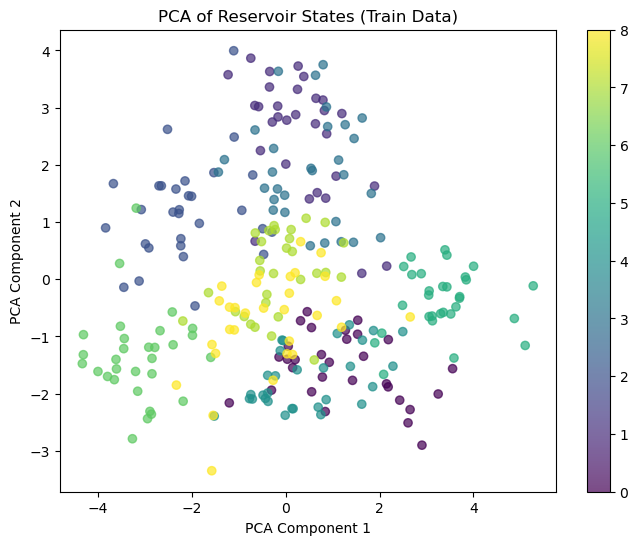

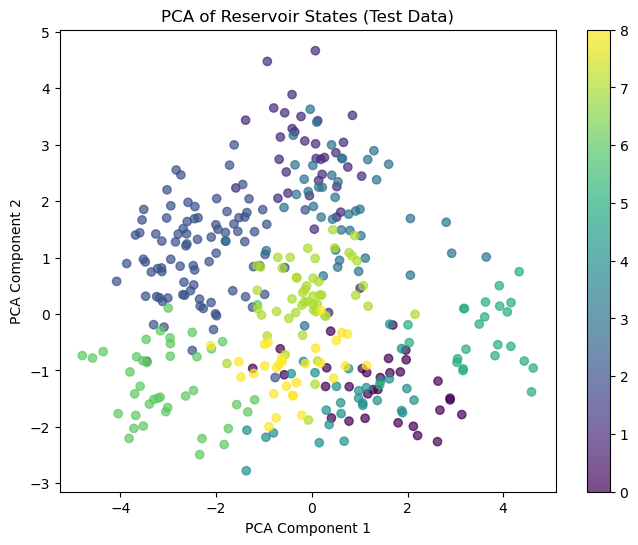

In [9]:
# %% [markdown]
# ### 4. PCAによる可視化

# %%
from sklearn.decomposition import PCA

# PCAで次元削減して2次元に
pca = PCA(n_components=2)
reservoir_states_pca = pca.fit_transform(reservoir_states_train)

# ラベルに応じて色分け
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reservoir_states_pca[:, 0], reservoir_states_pca[:, 1], c=Y_train_int, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("PCA of Reservoir States (Train Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# テストデータに対してもPCA適用
reservoir_states_pca_test = pca.transform(reservoir_states_test)

plt.figure(figsize=(8, 6))
scatter_test = plt.scatter(reservoir_states_pca_test[:, 0], reservoir_states_pca_test[:, 1], c=Y_test_int, cmap='viridis', alpha=0.7)
plt.colorbar(scatter_test)
plt.title("PCA of Reservoir States (Test Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()